In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from os import listdir

In [2]:
#gets percent cloud coverage in an image

def get_cloud_pct(img):
    
    cloud_mask = img[:,:,1] > 0.15
    n_cloud_pixels = np.count_nonzero(cloud_mask)
    n_total_pixels = img.shape[0] * img.shape[1]
    pct_cloud = n_cloud_pixels / n_total_pixels
    
    return pct_cloud

In [3]:
#predicts label of all pixels in an image

def predict_pixels_probas(img, scaler, model):
    
    #copy image array and reshape so channels are columns and pixels are rows
    img_copy = np.copy(img)
    img_copy = np.reshape(img_copy, (-1,13))
    
    #scale
    img_copy = scaler.transform(img_copy)
    
    #predict all the pixels and reshape for visualization
    preds = model.predict(img_copy)
    preds = np.reshape(preds, img[:,:,0].shape)
    
    #get prediction probability for all the pixels
    probas = model.predict_proba(img_copy)
    
    #reshape prediction that its a poppy - for visualization
    probas = np.reshape(probas[:,1], img[:,:,0].shape)
    
    return preds, probas

In [4]:
#plots visual check of predictions

def visual_check(preds, probas, img):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    axs[0].imshow(preds)
    axs[1].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1))
    a = axs[2].imshow(probas)
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    axs[0].title.set_text('Prediction')
    axs[2].title.set_text('Poppy probability')
    
    fig.colorbar(a,ax=axs[2])

In [5]:
#load scaler and model
scaler = pickle.load(open('/home/esther/shared/scaler_iter3.pkl', 'rb'))
clf_rf = pickle.load(open('/home/esther/shared/model_iter3.pkl', 'rb'))

In [54]:
#get list of files to label
year = '2020'
filenames = [x for x in os.listdir('/home/esther/shared') if x.endswith(".npy") \
             and 'labels' not in x and year in x]

print(len(filenames))
print(filenames)

34
['2020-03-02_grassmtn.npy', '2020-03-04_antelope.npy', '2020-03-04_elsinore.npy', '2020-03-07_grassmtn.npy', '2020-03-09_elsinore.npy', '2020-03-12_grassmtn.npy', '2020-03-14_antelope.npy', '2020-03-14_elsinore.npy', '2020-03-17_grassmtn.npy', '2020-03-19_antelope.npy', '2020-03-19_elsinore.npy', '2020-03-22_grassmtn.npy', '2020-03-24_antelope.npy', '2020-03-24_elsinore.npy', '2020-03-27_grassmtn.npy', '2020-03-29_antelope.npy', '2020-03-29_elsinore.npy', '2020-04-01_grassmtn.npy', '2020-04-03_antelope.npy', '2020-04-03_elsinore.npy', '2020-04-06_grassmtn.npy', '2020-04-08_elsinore.npy', '2020-04-11_grassmtn.npy', '2020-04-13_antelope.npy', '2020-04-13_elsinore.npy', '2020-04-16_grassmtn.npy', '2020-04-18_antelope.npy', '2020-04-18_elsinore.npy', '2020-04-21_grassmtn.npy', '2020-04-23_antelope.npy', '2020-04-23_elsinore.npy', '2020-04-26_grassmtn.npy', '2020-04-28_antelope.npy', '2020-04-28_elsinore.npy']


In [55]:
#make predictions for each file

date_loc_list = []
imgs_list = []
preds_list = []
probas_list = []

for name in filenames:
    
    #get image file
    filename = '/home/esther/shared/' + name
    img = np.load(filename)
    
    #discard if image has more than 50% cloud coverage
    pct_cloud = get_cloud_pct(img)
    if pct_cloud > 0.5:
        continue
    
    #make predictions and get prediction probabilities
    preds, probas = predict_pixels_probas(img, scaler, clf_rf)
    
    #put in list for visualization
    date_loc_list.append(name[0:-4])
    imgs_list.append(img)
    preds_list.append(preds)
    probas_list.append(probas)
    
    print(name)

2020-03-02_grassmtn.npy
2020-03-04_antelope.npy
2020-03-04_elsinore.npy
2020-03-09_elsinore.npy
2020-03-12_grassmtn.npy
2020-03-19_antelope.npy
2020-03-22_grassmtn.npy
2020-03-27_grassmtn.npy
2020-03-29_antelope.npy
2020-03-29_elsinore.npy
2020-04-01_grassmtn.npy
2020-04-03_antelope.npy
2020-04-03_elsinore.npy
2020-04-11_grassmtn.npy
2020-04-13_antelope.npy
2020-04-16_grassmtn.npy
2020-04-18_antelope.npy
2020-04-21_grassmtn.npy
2020-04-23_antelope.npy
2020-04-23_elsinore.npy
2020-04-26_grassmtn.npy
2020-04-28_antelope.npy
2020-04-28_elsinore.npy


In [56]:
len(date_loc_list)

23

In [301]:
#save as npz dictionary

preds_dict = {name:arr for name, arr in zip(date_loc_list, preds_list)}
probs_dict = {name:arr for name, arr in zip(date_loc_list, probas_list)}

np.savez('/home/esther/shared/preds_' + year, **preds_dict)
np.savez('/home/esther/shared/probs_' + year, **probs_dict)


'''
NOTES

load like this:
tmp = np.load('/home/esther/shared/preds_' + year + '.npz')

read like a dictionary:
arr = tmp['name']

get keys like this:
names = list(tmp)
''';

2020-03-02_grassmtn


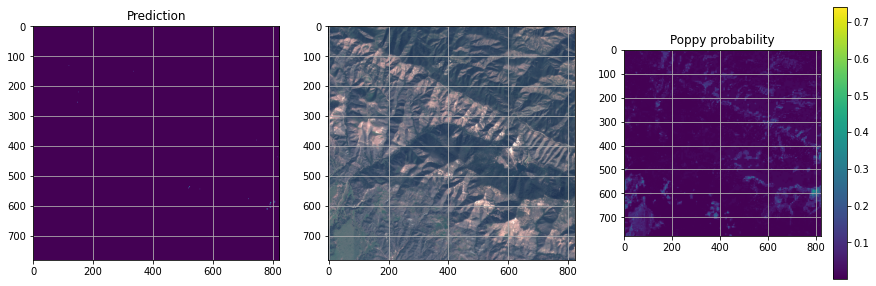

In [297]:
#sanity checks
n = 0
print(date_loc_list[n])
visual_check(preds_list[n], probas_list[n], imgs_list[n])